<a href="https://colab.research.google.com/github/komosam/word2Vec_CNN_-keras-/blob/master/word2Vec_%26_CNN(keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

#!pip install keras
# ref https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74

In [0]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

In [0]:
train_df  = pd.read_csv('train.csv',header=None)  ## Yelp review dataset
test_df   = pd.read_csv('test.csv',header=None)
## The column label is 2 and 1 instead of 0 and 1
train_df[0] = (train_df[0]==2).astype(int)
test_df[0]  = (test_df[0]==2).astype(int)

x_train = train_df[1]
y_train = train_df[0]

x_validation = test_df[1]
y_validation = test_df[0]

In [0]:

#word2vec_model = gensim.models.Word2Vec.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True) 

## train own word2Vec
word2vec_model = Word2Vec(x_validation,size=250,window=10,min_count=2,workers=10,iter=10)



In [0]:
### Tokenizing text:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [0]:
### Embedding


embeddings_index = {}
for w in word2vec_model.wv.vocab.keys():
  embeddings_index[w] = word2vec_model.wv[w]

## Limiting the number of words to 100000

num_words = 100000
embedding_matrix = np.zeros((num_words, 250))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [34]:
## Get max length of the sequence

length = []

for x in x_train:
  length.append(len(x.split()))
max(length)

1052

In [0]:
### Padding ----goes to input of model
x_train_seq = pad_sequences(sequences,maxlen=1000)

In [0]:
### Data prep for validation set 

sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=1000)

In [0]:
### Embedding Matrix 


In [9]:
# test_ modelling 

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten,Conv1D,GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

model_cnn_02 = Sequential()
e = Embedding(100000, 150,weights=[embedding_matrix], input_length=1000)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=2, batch_size=32, verbose=2)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint

In [39]:
input_layer = Input(shape=(1000,),dtype='int32')
embedding_layer = Embedding(100000, 250,weights=[embedding_matrix], input_length=1000)(input_layer)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(embedding_layer)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
#merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
merged = Dense(256, activation='relu')(bigram_branch)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[input_layer], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1000, 250)         25000000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 999, 100)          50100     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257 

In [40]:
filepath="CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Train on 560000 samples, validate on 38000 samples
Epoch 1/5
560000/560000 [==============================] - 437s 780us/step - loss: 0.1656 - acc: 0.9335 - val_loss: 0.1288 - val_acc: 0.9502

Epoch 00001: val_acc improved from -inf to 0.95024, saving model to CNN_best_weights.01-0.9502.hdf5
Epoch 2/5
560000/560000 [==============================] - 436s 779us/step - loss: 0.1118 - acc: 0.9583 - val_loss: 0.1289 - val_acc: 0.9512

Epoch 00002: val_acc improved from 0.95024 to 0.95118, saving model to CNN_best_weights.02-0.9512.hdf5
Epoch 3/5
560000/560000 [==============================] - 436s 778us/step - loss: 0.0844 - acc: 0.9695 - val_loss: 0.1327 - val_acc: 0.9525

Epoch 00003: val_acc improved from 0.95118 to 0.95247, saving model to CNN_best_weights.03-0.9525.hdf5
Epoch 4/5
560000/560000 [==============================] - 436s 778us/step - loss: 0.0610 - acc: 0.9786 - val_loss: 0.1546 - val_acc: 0.9500

Epoch 00004: val_acc did not improve from 0.95247
Epoch 5/5
560000/560000 [

In [14]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.01-0.9087.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

38000/38000 [==============================] - 1s 35us/step


[0.22363740062399914, 0.9086842105263158]

In [0]:
### BaseLine model TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_validation)


In [19]:
from sklearn.linear_model import LogisticRegression

lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)
lr_with_tfidf.score(x_test_tfidf,y_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9559473684210527

In [23]:
### Deep Learning Model 

sequences_test = tokenizer.texts_to_sequences(x_validation)
x_test_seq = pad_sequences(sequences_test, maxlen=45)
yhat_cnn = loaded_CNN_model.predict(x_test_seq)
loaded_CNN_model.evaluate(x=x_test_seq, y=y_validation)

38000/38000 [==============================] - 1s 34us/step


[0.22363740062399914, 0.9086842105263158]

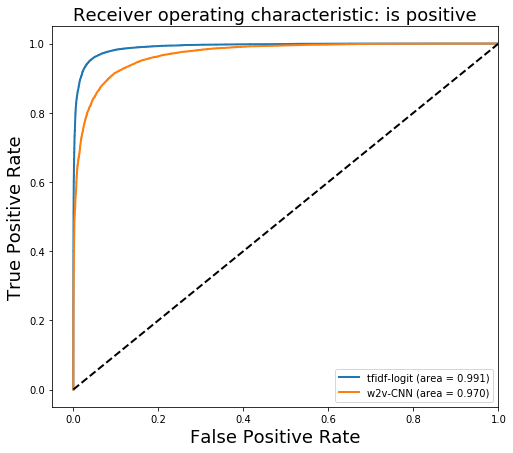

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



fpr, tpr, threshold = roc_curve(y_validation, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_validation, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()